In [1]:
from __future__ import division

from tematch_network import (build_te_embedder_c1d, preproc_dataset, batch_compute)
from train_utils import load_dataset, dataset_loc
import theano.tensor as T
from theano import function as tfn
import cPickle as pickle
import numpy as np
import time
import lasagne.layers as ll
from os.path import join
import matplotlib.pyplot as plt
import cv2
import random
import utool as ut
from itertools import product
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/home/zach/envs/thesis/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
model_loc = 'te_match_1000'
dset_loc = 'te_match_1000'

In [3]:

#model_name = 'jet_ep100_lr1e-2_pw_1e2.pkl'
model_name = 'modelpair.pkl'
model = ut.load_cPkl(join(dataset_loc, "Flukes/patches/%s" % join(model_loc, model_name)))

dset = load_dataset(join(dataset_loc, "Flukes/patches/%s" % dset_loc), normalize_method=None)

[util_io] * load_cPkl(u'.../te_match_1000/modelpair.pkl')
Loading /home/zach/data/Flukes/patches/te_match_1000
[util_io] * load_cPkl(u'.../te_match_1000/meanstd.pkl')
[util_io] * load_cPkl(u'.../te_match_1000/train.pkl')
[util_io] * load_cPkl(u'.../te_match_1000/val.pkl')
[util_io] * load_cPkl(u'.../te_match_1000/test.pkl')
Took 0.05 seconds


In [5]:
X = T.tensor3()


segmenter = build_te_embedder_c1d()
ll.set_all_param_values(segmenter, model)
model_outputs = [ll.get_output(intr_layer, X, deterministic=True) for intr_layer in ll.get_all_layers(segmenter)]
segmenter_out = ll.get_output(segmenter[-1], X, deterministic=True)
segmenter_fn = tfn([X], segmenter_out)

dset_for_model = {section:preproc_dataset(dset[section]) for section in ['train', 'valid', 'test']}

point_outputs = {sec:batch_compute(dset_for_model[sec]['Xall'], segmenter_fn, 32) for sec in ['train','valid','test']}

(3468, 4, 1000)
3145
(1156, 4, 1000)
341
(2421, 4, 1000)
670


In [6]:
list(enumerate(zip([(np.linalg.norm(i), i.shape) for i in 
                    ll.get_all_param_values(segmenter)],ll.get_all_params(segmenter))))

[(0, ((1.6378896, (16, 4, 3)), conv1.W)),
 (1, ((0.88736844, (16,)), conv1.b)),
 (2, ((0.15378605, (16,)), bn1.beta)),
 (3, ((1.2318518, (16,)), bn1.gamma)),
 (4, ((1.4061674, (16,)), bn1.mean)),
 (5, ((320.93515, (16,)), bn1.inv_std)),
 (6, ((2.2208526, (16, 16, 3)), conv2.W)),
 (7, ((0.67226279, (16,)), conv2.b)),
 (8, ((0.40944606, (16,)), bn2.beta)),
 (9, ((1.3149084, (16,)), bn2.gamma)),
 (10, ((0.92209041, (16,)), bn2.mean)),
 (11, ((21.098459, (16,)), bn2.inv_std)),
 (12, ((2.776557, (16, 16, 3)), conv3.W)),
 (13, ((0.60311109, (16,)), conv3.b)),
 (14, ((0.26648176, (16,)), bn3.beta)),
 (15, ((1.5801413, (16,)), bn3.gamma)),
 (16, ((1.4464403, (16,)), bn3.mean)),
 (17, ((14.617352, (16,)), bn3.inv_std)),
 (18, ((22.621456, (2000, 2048)), fc1.W)),
 (19, ((1.5190264, (2048,)), fc1.b)),
 (20, ((1.2631143, (2048,)), bn_fc1.beta)),
 (21, ((4.0916157, (2048,)), bn_fc1.gamma)),
 (22, ((4.7581005, (2048,)), bn_fc1.mean)),
 (23, ((1694.8019, (2048,)), bn_fc1.inv_std)),
 (24, ((8.6056652,

In [7]:
[(ind, i.shape[1:], np.average(np.std(i,axis=0)), l.name) for (ind, i), l in 
 zip(enumerate(point_outputs['valid']),ll.get_all_layers(segmenter))]

[(0, (), 0.057696309, 'input'),
 (1, (), 0.057714701, 'conv1'),
 (2, (), 0.057716344, 'mp1'),
 (3, (), 0.057700034, 'bn1'),
 (4, (), 0.05773399, 'conv2'),
 (5, (), 0.057701603, 'mp2'),
 (6, (), 0.057711191, 'bn2'),
 (7, (), 0.057700962, 'conv3'),
 (8, (), 0.057733011, 'mp3'),
 (9, (), 0.057734117, 'bn3'),
 (10, (), 0.057699867, 'dp0'),
 (11, (), 0.057698224, 'fc1'),
 (12, (), 0.05768406, 'bn_fc1'),
 (13, (), 0.057719044, 'dp1'),
 (14, (), 0.057703234, 'fc2'),
 (15, (), 0.057716008, 'bn_fc2'),
 (16, (), 0.057710938, 'dp2'),
 (17, (), 0.057726525, 'fc_embed'),
 (18, (), 0.057705238, 'embed_norm')]

In [8]:
print(np.std(point_outputs['valid'],axis=0))

[ 0.02399925  0.02526591  0.02368172  0.04626777  0.02523034  0.03243515
  0.00612574  0.03080647  0.00764653  0.02160255  0.07358763  0.04508323
  0.06465951  0.03097738  0.04072727  0.01197559  0.03304597  0.0314391
  0.03626421  0.03495179  0.0258271   0.02377552  0.01117919  0.02904127
  0.00972229  0.02427778  0.03301714  0.03182648  0.0432453   0.03273898
  0.04389127  0.03714509  0.0519794   0.01706326  0.03101941  0.01758269
  0.04152045  0.05755395  0.04383273  0.0452551   0.02678472  0.02638573
  0.00308943  0.05903644  0.05101674  0.04129181  0.02027224  0.0200852
  0.06769994  0.04565969  0.02554406  0.01162565  0.07810675  0.04569948
  0.03119074  0.05397259  0.06083424  0.02089116  0.01750013  0.03142801
  0.01810638  0.01550842  0.01335349  0.08567939  0.07449839  0.05292338
  0.02634235  0.05787091  0.01656082  0.0196178   0.01625768  0.00757777
  0.03977942  0.00976679  0.02370269  0.04749368  0.04474799  0.03300033
  0.01609725  0.04726734  0.04810705  0.09899523  0.0

In [15]:
example_triplets = ut.load_cPkl(join(dataset_loc, 'Flukes/patches/triplet_batches.pkl'))

[util_io] * load_cPkl(u'.../patches/triplet_batches.pkl')


0.0953193
0.181629


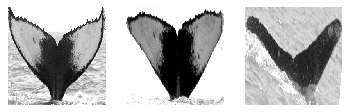

In [69]:
import plottool as pt
rand_ind = np.random.randint(len(example_triplets['anchor']))
pt.imshow(example_triplets['anchor'][rand_ind][0]*dset['std'] + dset['mean'], pnum=131)
pt.imshow(example_triplets['positive'][rand_ind][0]*dset['std'] + dset['mean'], pnum=132)
pt.imshow(example_triplets['negative'][rand_ind][0]*dset['std'] + dset['mean'], pnum=133)

print(np.linalg.norm(segmenter_fn(np.expand_dims(example_triplets['anchor'][rand_ind],axis=0)) - 
                     segmenter_fn(np.expand_dims(example_triplets['positive'][rand_ind],axis=0))))
print(np.linalg.norm(segmenter_fn(np.expand_dims(example_triplets['anchor'][rand_ind],axis=0)) - 
                     segmenter_fn(np.expand_dims(example_triplets['negative'][rand_ind],axis=0))))

In [92]:
example_pairs = ut.load_cPkl(join(dataset_loc, 'Flukes/patches/pair_batches.pkl'))

[util_io] * load_cPkl(u'.../patches/pair_batches.pkl')


0
[u'fb420430', 'zsl11639']
0.199678


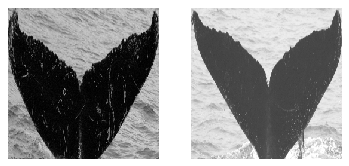

In [118]:
rand_ind = np.random.randint(len(example_pairs['img1']))
pt.imshow(example_pairs['img1'][rand_ind][0]*dset['std'] + dset['mean'], pnum=121)
pt.imshow(example_pairs['img2'][rand_ind][0]*dset['std'] + dset['mean'], pnum=122)
print(example_pairs['y'][rand_ind])
print(map(lambda x: dset['valid'][1][x], example_pairs['inds'][rand_ind]))
print(np.linalg.norm(segmenter_fn(np.expand_dims(example_pairs['img1'][rand_ind],axis=0)) - 
                     segmenter_fn(np.expand_dims(example_pairs['img2'][rand_ind],axis=0))))

In [12]:
from collections import defaultdict
embeddings = {sec:[{'embed':e, 'id':i} for e, i in zip(point_outputs[sec], dset_for_model[sec]['ids'])] 
              for sec in dset_for_model}

dist_method = lambda x, y: np.linalg.norm(x - y)
compare_on = 'embed'
def triplet_eval(embeddings, dist_method, compare_on, n_triplets=200, verbose=False):
    # generate triplets
    # the idea of a triplet is that we have an anchor sample and two other samples
    # one with the same id as the anchor and the other with a different id
    # (a1, a2, b) and we count a 0 if dist(a1,a2) < dist(a1,b)
    # this way we can evaluate a distance method using 2*n_triplets comparisons,
    # which is significantly faster
    id_curv_map = defaultdict(lambda: [])
    for curv in embeddings:
        id_curv_map[curv['id']].append(curv)
    
    good_count = 0
    # for complete coverage we'll generate a triplet for at most each id
    idlist = filter(lambda x: len(id_curv_map[x]) > 1, id_curv_map.keys())
    for _ in ut.ProgressIter(range(n_triplets), label='triplet', enabled=verbose):
        anchor = random.choice(idlist)
        random.shuffle(id_curv_map[anchor])
        negative = random.choice(filter(lambda x: x != anchor, idlist))
        random.shuffle(id_curv_map[negative])
        anchor_pos_dist = dist_method(id_curv_map[anchor][0][compare_on], 
                                      id_curv_map[anchor][1][compare_on],)
        anchor_neg_dist = dist_method(id_curv_map[anchor][0][compare_on], 
                                      id_curv_map[negative][0][compare_on],)
        #print("Distance between two instances of %s: %0.2f" % (anchor, anchor_pos_dist))
        #print("Distance between %s and %s: %0.2f" % (anchor, negative, anchor_neg_dist))
        if anchor_pos_dist + 0.2 < anchor_neg_dist:
            good_count += 1

    return good_count / float(n_triplets)

triplet_eval(embeddings['test'], dist_method, compare_on)

0.325

In [13]:
# Let's do an actual ranking test

def rank_eval(embeddings, k=5, verbose=False):
    found_ins = [0]*(k+1)
    tic = time.time()
    hist = defaultdict(lambda: 0)
    for e in embeddings:
        hist[e['id']] += 1
    
    bad_ids = set(filter(lambda x: hist[x] == 1, hist.keys()))
    for qimg in ut.ProgressIter(range(len(embeddings)), lbl='QueryImage', enabled=(verbose > 0)):
        if embeddings[qimg]['id'] in bad_ids:
            continue
        db = [e for ind, e in enumerate(embeddings) if ind != qimg]
        #db = curvatures
        dists = defaultdict(lambda: [])
        eval_tic = time.time()
        db_embeds = np.stack([e['embed'] for e in db],axis=0)
        db_dists = np.linalg.norm(embeddings[qimg]['embed'] - db_embeds,axis=1)
        # collect them into the dists dictionary
        for db_dist, id_ in zip(db_dists, [e['id'] for e in db]):
            dists[id_].append(db_dist)
        
        id_dists = {id_:np.average(dists[id_]) for id_ in dists}
        top_k = sorted(id_dists.keys(),key=lambda x: id_dists[x])[:k]
        try:
            found_k = top_k.index(embeddings[qimg]['id'])
        except ValueError:
            found_k = -1
        if verbose > 0:
            print("Average distance for correct id: %0.2f, giving k=%d" % (id_dists[embeddings[qimg]['id']],
                                                                           found_k))
            print("Distance for k=0: %0.2f" % id_dists[top_k[0]])
        found_ins[found_k] += 1
        eval_toc = time.time() - eval_tic
        #if verbose > 0:
        #    print("Took %0.2f seconds to evaluate image %d" % (eval_toc, qimg))
    toc = time.time() - tic
    print("Took %0.2f seconds" % toc)
    found_ins = [f_in / len(embeddings) for f_in in found_ins]
    return found_ins

rank_eval(embeddings['test'], verbose=False)

Took 6.21 seconds


[0.0019880715705765406,
 0.0006626905235255136,
 0.0019880715705765406,
 0.0013253810470510272,
 0.0019880715705765406,
 0.29092113982770046]

In [ ]:


def show_output(originals, true_labels, outputs, ind, stage=-1, weights=None):
    # the [0] indexes into the channel
    dset_img = ((originals[ind][0]*dset['std']) + dset['mean']).astype(np.uint8)
    dset_label = true_labels[ind][0,:,:] # only show the trailing edge label
    
    pred_label = outputs[-1][ind]
    network_stage = outputs[stage][ind].swapaxes(0,2)
    plt.gray()
    f, trueax = plt.subplots(2,2, figsize=(15,15))
    f.suptitle("Outputs and True value comparison")
    for i in trueax.flatten():
        i.axis('off')
    trueax[0,0].imshow(dset_label)
    trueax[0,1].imshow(pred_label[0,:,:])
    trueax[1,0].imshow(dset_img)
    #trueax[1,1].imshow(weights[ind])
    trueax[1,1].imshow(np.argmax(pred_label,axis=0))
    
    nfilters = network_stage.shape[-1]
    if nfilters > 1:  
        square_size = int(np.sqrt(nfilters) + 0.5)
        ncols = square_size
        nrows = ncols + int((square_size % nfilters > 0))
    else:
        square_size = 1
    print(network_stage)
    plt.gray()
    if nfilters > 1:
        f, netax = plt.subplots(nrows, ncols, figsize=(15,15))
        if len(netax.shape) == 1:
            # fucking hell matplotlib
            netax = netax.reshape(-1,1)
        f.suptitle('Network stage: %d' % stage)

        for i, j in product(range(nrows), range(ncols)):
            this_ax = netax[i, j]
            this_ax.axis('off')
            #this_ax.get_xaxis().set_visible(False)
            #this_ax.get_yaxis().set_visible(False)
            #print(i)
            if i < nfilters:
                this_ax.imshow(network_stage[:,:,i].T, interpolation='none')
    else:
        # probably an input or stn
        #print(network_stage[:,:,0])
        #print(outputs[stage-1][ind].reshape(2,3))
        denormed =  (dset['std']*network_stage[:,:,0] + dset['mean']).astype(np.uint8).T
        #denormed = network_stage[:,:,0].astype(np.uint8)
        #print(denormed)

        f, netax = plt.subplots(1, figsize=(7.5,7.5))
        netax.axis('off')
        netax.imshow(denormed, interpolation='none')
    #ax[2].imshow(network_stage)

sec = 'valid'
show_output(dset_for_model[sec]['X'], dset_for_model[sec]['y'], point_outputs[sec], 
            random.choice(range(dset_for_model[sec]['X'].shape[0])), stage=4, weights=dset_for_model[sec]['pixelw'])

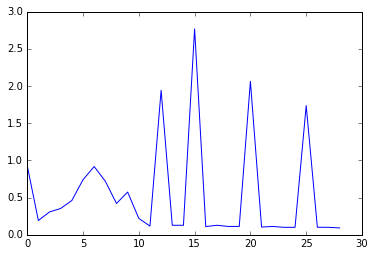

In [9]:
#print(len(point_outputs_valid))
n_layers = len(point_outputs[sec])
#plt.yscale('log')
plt.plot([np.average(np.std(point_outputs[sec][i],axis=0)) for i in range(n_layers)])

0.0923186
0.0171012


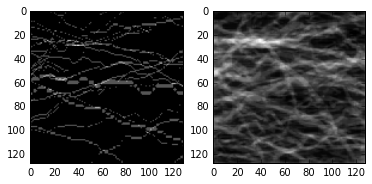

In [10]:
avg_label = np.average(dset_for_model[sec]['y'],axis=0)
avg_pred = np.average(point_outputs[sec][-1],axis=0)
f, ax = plt.subplots(1, 2)
ax[0].imshow(avg_label[0,:,:])
ax[1].imshow(avg_pred[0,:,:])

print(np.average(np.std(point_outputs[sec][-1],axis=0)))
print(np.average(np.std(dset_for_model[sec]['y'],axis=0)))

In [11]:
from IPython.display import Image 
Image(filename='./losses.png')

IOError: [Errno 2] No such file or directory: u'./losses.png'

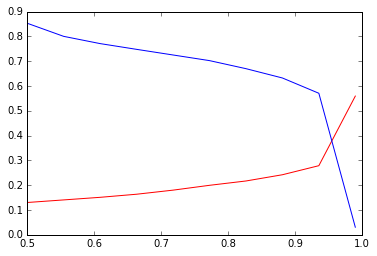

In [13]:
# false positive rate
def precision_recall(true, pred, pos_thresh=0.5):
    # given a set of predicted labels and true labels, figure out what the rate of false positive to true
    # positives is
    # assume decision axis is axis 1
    thresh = lambda x: x[:,0,:,:] > pos_thresh # this makes sense
    thresh_true = thresh(true)
    thresh_pred = thresh(pred)
    # now it's 0 where there's bg, and 1 where there's te
    # if we subtract true from pred, we'll have -1 for a false neg and 1 for a false pos
    n_tp = np.sum(np.logical_and(thresh_true, thresh_pred))
    n_tn = np.sum(1 - np.logical_and(thresh_true, thresh_pred))
    n_fp = np.sum((thresh_pred.astype(np.int) - thresh_true.astype(np.int)) > 0)
    n_fn = np.sum((thresh_pred.astype(np.int) - thresh_true.astype(np.int)) < 0)
    precision = (n_tp) / (n_tp + n_fp)
    recall = (n_tp) / (n_fn + n_tp)
    return precision, recall

thresholds = np.linspace(0.5,.99,10)
pr_curve = [precision_recall(dset_for_model[sec]['y'], point_outputs[sec][-1], pos_thresh=i) for i in thresholds]
plt.plot(thresholds, zip(*pr_curve)[0], color='r')
plt.plot(thresholds, zip(*pr_curve)[1], color='b')

In [14]:
# all bg accuracy?
np.sum(dset_for_model[sec]['y'][:,0,:,:] == np.zeros(dset_for_model[sec]['y'][:,0,:,:].shape,dtype=np.int)) / np.product(dset_for_model[sec]['y'][:,0,:,:].shape)

0.99794292449951172

### Write model to lev's public model serv

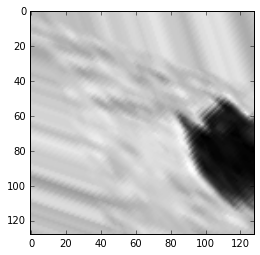

In [15]:
M = np.eye(3, dtype=np.float32)[:-1,:] + 0.5
test_img = dset['std']*dset_for_model[sec]['X'][0][0] + dset['mean']
plt.imshow(cv2.warpAffine(test_img, M, (128,128), 0, 0, cv2.BORDER_REPLICATE))

In [16]:
dset_for_model[sec]['X'][0][0]

array([[ 0.43283632,  0.41757536,  0.38705343, ...,  0.6464898 ,
         0.69227266,  0.69227266],
       [ 0.43283632,  0.43283632,  0.41757536, ...,  0.73805559,
         0.78383845,  0.75331652],
       [ 0.47861919,  0.49388015,  0.47861919, ...,  0.81436038,
         0.87540424,  0.81436038],
       ..., 
       [ 0.73805559,  0.70753366,  0.66175073, ...,  0.41757536,
         0.3565315 ,  0.31074861],
       [ 0.70753366,  0.69227266,  0.69227266, ...,  0.37179247,
         0.37179247,  0.32600957],
       [ 0.58544594,  0.60070688,  0.60070688, ...,  0.29548764,
         0.26496571,  0.24970476]], dtype=float32)